# 專題

# 基本目標

- 爬下文章，透過 jieba 等斷詞將文章拆解
- 可以簡單的計算同樣文字出現的頻率或是透過 TFIDF 的統計方式計算
- 將經常出現的 stop words 過濾掉之後對頻率進行排名
- 將結果透過 wordcloud 文字雲的方式呈現


# 進階目標

- 透過不同帳號，但是相同 IP 且政治用語的詞頻分佈類似的定位成網軍
- 進一步分析帳號是否在特定期間 (e.g. 選舉) 有明顯的活動特性
- 如果不同帳號但是政治用語的詞頻分佈類似，進一步判斷這些高頻率的單字是positive / negative 來歸納兩個帳號之間是否具有相同政治立場



In [325]:
import requests
import re
import json
import jieba
import pandas as pd
import matplotlib.pyplot as plt
import _thread
import time
from datetime import datetime
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from urllib.parse import urljoin
from bs4 import BeautifulSoup

# PTT 八卦版網址
#PTT_URL = 'https://www.ptt.cc/bbs/Gossiping/index.html'
PTT_URL = 'https://www.ptt.cc/bbs/Gossiping/index27901.html'
url_host = 'https://www.ptt.cc'
# 爬取文章數
maxCount=1000

In [326]:


# 設定停用詞
stopwords = []
with open('stopwords-master/cn_stopwords.txt', 'r', encoding='utf-8') as f:
    for line in f:
        if len(line)>0:
            stopwords.append(line.strip())
            
# 設定網軍詞
political = []
with open('mgck2017/政黑_繁體.txt', 'r', encoding='utf-8') as f:
    for line in f:
        if len(line)>0:
            political.append(line.strip())    

#Jieba

In [1]:

#計算結巴字詞的個數
def jiebaCountWordWithContent(data,content):
    jieba.set_dictionary('dict.user.big.txt')
    words = jieba.cut(content, cut_all=False)
    for word in words:
            if not regex.match(word):
                if word in data:
                    count=data[word]+1
                    tmp={}
                    tmp={word:count}
                    data.update(tmp)
                else:
                    data[word]=1
                
    return data


#計算結巴字詞的個數
def jiebaContent(stopwords,wordSet,content):
    jieba.set_dictionary('dict.user.big.txt')
    words = jieba.cut(content, cut_all=False)
    wordContentList = list()
    for word in words:
            if not regex.match(word):
                #if word not in wordSet:
                #    print(word)
                
                #print(stopwords)
                if word not in wordSet and word not in stopwords:
                    wordSet.add(word)
                    
                if word not in wordContentList and word not in stopwords:
                    wordContentList.append(word)
                
    return wordSet,wordContentList;

#TF-IDF

In [328]:
def computeTF(wordDict, bagOfWords):
    tfDict = {}
    bagOfWordsCount = len(bagOfWords)
    for word, count in wordDict.items():
        tfDict[word] = count / float(bagOfWordsCount)
    return tfDict

In [329]:
def computeIDF(documents):
    import math
    N = len(documents)
    
    idfDict = dict.fromkeys(documents[0].keys(), 0)
    for document in documents:
        for word, val in document.items():
            if val > 0:
                idfDict[word] += 1
    
    for word, val in idfDict.items():
        idfDict[word] = math.log(N / float(val))
    return idfDict

In [330]:
def computeTFIDF(tfBagOfWords, idfs):
    tfidf = {}
    for word, val in tfBagOfWords.items():
        tfidf[word] = val * idfs[word]
    return tfidf

In [331]:
def filterIP(ipTemp):
    pattern_1 = re.compile('(\d{1,3}).(\d{1,3}).(\d{1,3}).(\d{1,3})')
    pattern_2 = re.compile('^(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)$')
    result_1 = re.search(pattern_1, ipTemp)
    result_2 = re.search(pattern_2, result_1.group())
    if result_2:
        return result_2.group()
    else:
        print(ipTemp,'is No Match')
    

- 爬下文章，透過 jieba 等斷詞將文章拆解


In [332]:
def crawl_article(authorInfo,stopwords,wordSet,url):
    response = requests.get(url, cookies={'over18': '1'})
    #print(response)
    # 假設網頁回應不是 200 OK 的話, 我們視為傳送請求失敗
    if response.status_code != 200:
        print('Error - {} is not available to access'.format(url))
        return
    
    # 將網頁回應的 HTML 傳入 BeautifulSoup 解析器, 方便我們根據標籤 (tag) 資訊去過濾尋找
    soup = BeautifulSoup(response.text)

    # 取得文章內容主體
    main_content = soup.find(id='main-content')
    
    # 取得作者資訊
    author = main_content.find_all('span',class_='article-meta-value')[0].text
    ip=''
    for contentInfo in main_content.find_all('span',class_='f2'):
        if '※ 發信站: 批踢踢實業坊(ptt.cc), 來自: ' in contentInfo.text:
            ip = filterIP(contentInfo.text)

    
    # 移除文章主體中 '※ 發信站:', '◆ From:', 空行及多餘空白 (※ = u'\u203b', ◆ = u'\u25c6')
    # 保留英數字, 中文及中文標點, 網址, 部分特殊符號
    #
    # 透過 .stripped_strings 的方式可以快速移除多餘空白並取出文字, 可參考官方文件 
    #  - https://www.crummy.com/software/BeautifulSoup/bs4/doc/#strings-and-stripped-strings
    filtered = []
    for v in main_content.stripped_strings:
        # 假如字串開頭不是特殊符號或是以 '--' 開頭的, 我們都保留其文字
        if v[0] not in [u'※', u'◆'] and v[:2] not in [u'--']:
            filtered.append(v)

    # 定義一些特殊符號與全形符號的過濾器
    expr = re.compile(u'[^一-龥。；，：“”（）、？《》\s\w:/-_.?~%()]')
    for i in range(len(filtered)):
        filtered[i] = re.sub(expr, '', filtered[i])
    
    # 移除空白字串, 組合過濾後的文字即為文章本文 (content)
    filtered = [i for i in filtered if i]
    content = ' '.join(filtered)
    #print(content)
    
    wordSet,wordContentList=jiebaContent(stopwords,wordSet,content)
    
    #authorInfo[count]={ip:author}
    tmp=dict()
    tmp={'ip':ip,'author':author,'url':url}
    authorInfo[count]=tmp
    
    return authorInfo,wordSet,wordContentList;

In [333]:
resp = requests.get(PTT_URL, cookies={'over18': '1'})
soup = BeautifulSoup(resp.text)
count=0 #計算文章數
wordSet=set()
authorInfo=dict()
wordContentList=dict(list())
#nextPage=soup.find(id='action-bar-container').find_all('a',class_='wide')[1].get('href')
nextPage=''
#PTT_URL='https://www.ptt.cc/bbs/Gossiping/index39052.html'
while count<maxCount:
    # 對文章列表送出請求並取得列表主體
    if count>0:
        PTT_URL=url_host+soup.find(id='action-bar-container').find_all('a',class_='wide')[1].get('href')
        
    resp = requests.get(PTT_URL, cookies={'over18': '1'})
    soup = BeautifulSoup(resp.text)
    main_list = soup.find('div', class_='bbs-screen')
    #nextPage=soup.find(id='action-bar-container').find_all('a',class_='wide')[1].get('href')

    #count=0 #計算文章數
    # 依序檢查文章列表中的 tag, 遇到分隔線就結束, 忽略這之後的文章
    for div in main_list.findChildren('div', recursive=False):
        #print('poncc-start:',count,class_name)
        class_name = div.attrs['class']
        # 遇到分隔線要處理的情況
        if class_name and 'r-list-sep' in class_name:
            #print('Reach the last article')
            break
        # 遇到目標文章
        if class_name and 'r-ent' in class_name:
            div_title = div.find('div', class_='title')
            a_title = div_title.find('a', href=True)
            # 排除已刪除或違反版規貼文
            if a_title==None:
                #print('poncc-debug-title:',count)
                continue
            print('poncc-debug:',count)
            article_URL = urljoin(PTT_URL, a_title['href'])
            article_title = a_title.text
            #print('Parse {} - {}'.format(article_title, article_URL))

            # 呼叫上面寫好的 function 來對文章中的字詞進行爬蟲與計數
            authorInfo,wordSet,tmp = crawl_article(authorInfo,stopwords,wordSet,article_URL)
            wordContentList[count]=tmp
            count+=1;
        #第n篇文章結束   
        if count>=maxCount:
            print('end')
            break;
#print('poncc-cout:',count)


poncc-debug: 0


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.103 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache


poncc-debug: 1


Loading model cost 1.154 seconds.
Prefix dict has been built successfully.


poncc-debug: 2


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.090 seconds.
Prefix dict has been built successfully.


poncc-debug: 3


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.160 seconds.
Prefix dict has been built successfully.


poncc-debug: 4


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.106 seconds.
Prefix dict has been built successfully.


poncc-debug: 5


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.148 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...


poncc-debug: 6


Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.058 seconds.
Prefix dict has been built successfully.


poncc-debug: 7


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.134 seconds.
Prefix dict has been built successfully.


poncc-debug: 8


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.100 seconds.
Prefix dict has been built successfully.


poncc-debug: 9


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.160 seconds.
Prefix dict has been built successfully.


poncc-debug: 10


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.067 seconds.
Prefix dict has been built successfully.


poncc-debug: 11


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.177 seconds.
Prefix dict has been built successfully.


poncc-debug: 12


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.092 seconds.
Prefix dict has been built successfully.


poncc-debug: 13


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.154 seconds.
Prefix dict has been built successfully.


poncc-debug: 14


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.045 seconds.
Prefix dict has been built successfully.


poncc-debug: 15


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.141 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache


poncc-debug: 16


Loading model cost 1.079 seconds.
Prefix dict has been built successfully.


poncc-debug: 17


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.143 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...


poncc-debug: 18


Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.076 seconds.
Prefix dict has been built successfully.


poncc-debug: 19


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.038 seconds.
Prefix dict has been built successfully.


poncc-debug: 20


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.033 seconds.
Prefix dict has been built successfully.


poncc-debug: 21


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.042 seconds.
Prefix dict has been built successfully.


poncc-debug: 22


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.996 seconds.
Prefix dict has been built successfully.


poncc-debug: 23


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.025 seconds.
Prefix dict has been built successfully.


poncc-debug: 24


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.012 seconds.
Prefix dict has been built successfully.


poncc-debug: 25


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.080 seconds.
Prefix dict has been built successfully.


poncc-debug: 26


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.021 seconds.
Prefix dict has been built successfully.


poncc-debug: 27


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.082 seconds.
Prefix dict has been built successfully.


poncc-debug: 28


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.030 seconds.
Prefix dict has been built successfully.


poncc-debug: 29


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.067 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...


poncc-debug: 30


Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.990 seconds.
Prefix dict has been built successfully.


poncc-debug: 31


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.037 seconds.
Prefix dict has been built successfully.


poncc-debug: 32


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.033 seconds.
Prefix dict has been built successfully.


poncc-debug: 33


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.036 seconds.
Prefix dict has been built successfully.


poncc-debug: 34


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.005 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...


poncc-debug: 35


Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.046 seconds.
Prefix dict has been built successfully.


poncc-debug: 36


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.015 seconds.
Prefix dict has been built successfully.


poncc-debug: 37


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.037 seconds.
Prefix dict has been built successfully.


poncc-debug: 38


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.003 seconds.
Prefix dict has been built successfully.


poncc-debug: 39


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.027 seconds.
Prefix dict has been built successfully.


poncc-debug: 40


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.016 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...


poncc-debug: 41


Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.045 seconds.
Prefix dict has been built successfully.


poncc-debug: 42


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.022 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache


poncc-debug: 43


Loading model cost 1.061 seconds.
Prefix dict has been built successfully.


poncc-debug: 44


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.014 seconds.
Prefix dict has been built successfully.


poncc-debug: 45


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.047 seconds.
Prefix dict has been built successfully.


poncc-debug: 46


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.004 seconds.
Prefix dict has been built successfully.


poncc-debug: 47


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.047 seconds.
Prefix dict has been built successfully.


poncc-debug: 48


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.030 seconds.
Prefix dict has been built successfully.


poncc-debug: 49


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.044 seconds.
Prefix dict has been built successfully.


poncc-debug: 50


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.997 seconds.
Prefix dict has been built successfully.


poncc-debug: 51


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.051 seconds.
Prefix dict has been built successfully.


poncc-debug: 52


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.029 seconds.
Prefix dict has been built successfully.


poncc-debug: 53


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.029 seconds.
Prefix dict has been built successfully.


poncc-debug: 54


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.014 seconds.
Prefix dict has been built successfully.


poncc-debug: 55


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.034 seconds.
Prefix dict has been built successfully.


poncc-debug: 56


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.033 seconds.
Prefix dict has been built successfully.


poncc-debug: 57


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.030 seconds.
Prefix dict has been built successfully.


poncc-debug: 58


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.999 seconds.
Prefix dict has been built successfully.


poncc-debug: 59


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.072 seconds.
Prefix dict has been built successfully.


poncc-debug: 60


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.018 seconds.
Prefix dict has been built successfully.


poncc-debug: 61


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.052 seconds.
Prefix dict has been built successfully.


poncc-debug: 62


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.030 seconds.
Prefix dict has been built successfully.


poncc-debug: 63


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.046 seconds.
Prefix dict has been built successfully.


poncc-debug: 64


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.017 seconds.
Prefix dict has been built successfully.


poncc-debug: 65


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.043 seconds.
Prefix dict has been built successfully.


poncc-debug: 66


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.017 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache


poncc-debug: 67


Loading model cost 1.044 seconds.
Prefix dict has been built successfully.


poncc-debug: 68


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.034 seconds.
Prefix dict has been built successfully.


poncc-debug: 69


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.031 seconds.
Prefix dict has been built successfully.


poncc-debug: 70


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.999 seconds.
Prefix dict has been built successfully.


poncc-debug: 71


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.039 seconds.
Prefix dict has been built successfully.


poncc-debug: 72


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.018 seconds.
Prefix dict has been built successfully.


poncc-debug: 73


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.042 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache


poncc-debug: 74


Loading model cost 1.015 seconds.
Prefix dict has been built successfully.


poncc-debug: 75


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.050 seconds.
Prefix dict has been built successfully.


poncc-debug: 76


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.019 seconds.
Prefix dict has been built successfully.


poncc-debug: 77


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.039 seconds.
Prefix dict has been built successfully.


poncc-debug: 78


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.017 seconds.
Prefix dict has been built successfully.


poncc-debug: 79


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.066 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache


poncc-debug: 80


Loading model cost 1.079 seconds.
Prefix dict has been built successfully.


poncc-debug: 81


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.091 seconds.
Prefix dict has been built successfully.


poncc-debug: 82


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.999 seconds.
Prefix dict has been built successfully.


poncc-debug: 83


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.034 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache


poncc-debug: 84


Loading model cost 1.028 seconds.
Prefix dict has been built successfully.


poncc-debug: 85


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.028 seconds.
Prefix dict has been built successfully.


poncc-debug: 86


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.000 seconds.
Prefix dict has been built successfully.


poncc-debug: 87


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.049 seconds.
Prefix dict has been built successfully.


poncc-debug: 88


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.028 seconds.
Prefix dict has been built successfully.


poncc-debug: 89


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.034 seconds.
Prefix dict has been built successfully.


poncc-debug: 90


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.014 seconds.
Prefix dict has been built successfully.


poncc-debug: 91


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.038 seconds.
Prefix dict has been built successfully.


poncc-debug: 92


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.019 seconds.
Prefix dict has been built successfully.


poncc-debug: 93


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.031 seconds.
Prefix dict has been built successfully.


poncc-debug: 94


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.997 seconds.
Prefix dict has been built successfully.


poncc-debug: 95


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.034 seconds.
Prefix dict has been built successfully.


poncc-debug: 96


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.012 seconds.
Prefix dict has been built successfully.


poncc-debug: 97


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.023 seconds.
Prefix dict has been built successfully.


poncc-debug: 98


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.023 seconds.
Prefix dict has been built successfully.


poncc-debug: 99


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.047 seconds.
Prefix dict has been built successfully.


poncc-debug: 100


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.023 seconds.
Prefix dict has been built successfully.


poncc-debug: 101


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.059 seconds.
Prefix dict has been built successfully.


poncc-debug: 102


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.999 seconds.
Prefix dict has been built successfully.


poncc-debug: 103


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.029 seconds.
Prefix dict has been built successfully.


poncc-debug: 104


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.029 seconds.
Prefix dict has been built successfully.


poncc-debug: 105


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.028 seconds.
Prefix dict has been built successfully.


poncc-debug: 106


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.020 seconds.
Prefix dict has been built successfully.


poncc-debug: 107


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.035 seconds.
Prefix dict has been built successfully.


poncc-debug: 108


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.035 seconds.
Prefix dict has been built successfully.


poncc-debug: 109


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.033 seconds.
Prefix dict has been built successfully.


poncc-debug: 110


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.011 seconds.
Prefix dict has been built successfully.


poncc-debug: 111


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.038 seconds.
Prefix dict has been built successfully.


poncc-debug: 112


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.036 seconds.
Prefix dict has been built successfully.


poncc-debug: 113


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.040 seconds.
Prefix dict has been built successfully.


poncc-debug: 114


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.007 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...


poncc-debug: 115


Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.041 seconds.
Prefix dict has been built successfully.


poncc-debug: 116


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.032 seconds.
Prefix dict has been built successfully.


poncc-debug: 117


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.047 seconds.
Prefix dict has been built successfully.


poncc-debug: 118


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.011 seconds.
Prefix dict has been built successfully.


poncc-debug: 119


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.035 seconds.
Prefix dict has been built successfully.


poncc-debug: 120


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.018 seconds.
Prefix dict has been built successfully.


poncc-debug: 121


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.051 seconds.
Prefix dict has been built successfully.


poncc-debug: 122


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.031 seconds.
Prefix dict has been built successfully.


poncc-debug: 123


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.015 seconds.
Prefix dict has been built successfully.


poncc-debug: 124


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.032 seconds.
Prefix dict has been built successfully.


poncc-debug: 125


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.037 seconds.
Prefix dict has been built successfully.


poncc-debug: 126


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.023 seconds.
Prefix dict has been built successfully.


poncc-debug: 127


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.041 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache


poncc-debug: 128


Loading model cost 1.022 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache


poncc-debug: 129


Loading model cost 1.032 seconds.
Prefix dict has been built successfully.


poncc-debug: 130


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.004 seconds.
Prefix dict has been built successfully.


poncc-debug: 131


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.037 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...


poncc-debug: 132


Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.017 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache


poncc-debug: 133


Loading model cost 1.032 seconds.
Prefix dict has been built successfully.


poncc-debug: 134


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.024 seconds.
Prefix dict has been built successfully.


poncc-debug: 135


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.036 seconds.
Prefix dict has been built successfully.


poncc-debug: 136


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.033 seconds.
Prefix dict has been built successfully.


poncc-debug: 137


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.029 seconds.
Prefix dict has been built successfully.


poncc-debug: 138


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.996 seconds.
Prefix dict has been built successfully.


poncc-debug: 139


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.027 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache


poncc-debug: 140


Loading model cost 1.018 seconds.
Prefix dict has been built successfully.


poncc-debug: 141


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.023 seconds.
Prefix dict has been built successfully.


poncc-debug: 142


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.000 seconds.
Prefix dict has been built successfully.


poncc-debug: 143


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.038 seconds.
Prefix dict has been built successfully.


poncc-debug: 144


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.023 seconds.
Prefix dict has been built successfully.


poncc-debug: 145


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.030 seconds.
Prefix dict has been built successfully.


poncc-debug: 146


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.


poncc-debug: 147


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.032 seconds.
Prefix dict has been built successfully.


poncc-debug: 148


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.014 seconds.
Prefix dict has been built successfully.


poncc-debug: 149


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.027 seconds.
Prefix dict has been built successfully.


poncc-debug: 150


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.002 seconds.
Prefix dict has been built successfully.


poncc-debug: 151


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.030 seconds.
Prefix dict has been built successfully.


poncc-debug: 152


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.029 seconds.
Prefix dict has been built successfully.


poncc-debug: 153


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.027 seconds.
Prefix dict has been built successfully.


poncc-debug: 154


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.003 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache


poncc-debug: 155


Loading model cost 1.047 seconds.
Prefix dict has been built successfully.


poncc-debug: 156


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.023 seconds.
Prefix dict has been built successfully.


poncc-debug: 157


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.090 seconds.
Prefix dict has been built successfully.


poncc-debug: 158


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.006 seconds.
Prefix dict has been built successfully.


poncc-debug: 159


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.023 seconds.
Prefix dict has been built successfully.


poncc-debug: 160


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.020 seconds.
Prefix dict has been built successfully.


poncc-debug: 161


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.027 seconds.
Prefix dict has been built successfully.


poncc-debug: 162


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.011 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache


poncc-debug: 163


Loading model cost 1.030 seconds.
Prefix dict has been built successfully.


poncc-debug: 164


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.013 seconds.
Prefix dict has been built successfully.


poncc-debug: 165


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.032 seconds.
Prefix dict has been built successfully.


poncc-debug: 166


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.008 seconds.
Prefix dict has been built successfully.


poncc-debug: 167


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.018 seconds.
Prefix dict has been built successfully.


poncc-debug: 168


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.014 seconds.
Prefix dict has been built successfully.


poncc-debug: 169


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.028 seconds.
Prefix dict has been built successfully.


poncc-debug: 170


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.003 seconds.
Prefix dict has been built successfully.


poncc-debug: 171


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.067 seconds.
Prefix dict has been built successfully.


poncc-debug: 172


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.017 seconds.
Prefix dict has been built successfully.


poncc-debug: 173


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.025 seconds.
Prefix dict has been built successfully.


poncc-debug: 174


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.002 seconds.
Prefix dict has been built successfully.


poncc-debug: 175


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.026 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache


poncc-debug: 176


Loading model cost 1.016 seconds.
Prefix dict has been built successfully.


poncc-debug: 177


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.047 seconds.
Prefix dict has been built successfully.


poncc-debug: 178


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.


poncc-debug: 179


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.036 seconds.
Prefix dict has been built successfully.


poncc-debug: 180


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.029 seconds.
Prefix dict has been built successfully.


poncc-debug: 181


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.029 seconds.
Prefix dict has been built successfully.


poncc-debug: 182


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.008 seconds.
Prefix dict has been built successfully.


poncc-debug: 183


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...


poncc-debug: 184


Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.021 seconds.
Prefix dict has been built successfully.


poncc-debug: 185


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.022 seconds.
Prefix dict has been built successfully.


poncc-debug: 186


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.001 seconds.
Prefix dict has been built successfully.


poncc-debug: 187


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.034 seconds.
Prefix dict has been built successfully.


poncc-debug: 188


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.025 seconds.
Prefix dict has been built successfully.


poncc-debug: 189


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.040 seconds.
Prefix dict has been built successfully.


poncc-debug: 190


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.005 seconds.
Prefix dict has been built successfully.


poncc-debug: 191


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.038 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...


poncc-debug: 192


Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.006 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache


poncc-debug: 193


Loading model cost 1.051 seconds.
Prefix dict has been built successfully.


poncc-debug: 194


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.007 seconds.
Prefix dict has been built successfully.


poncc-debug: 195


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.017 seconds.
Prefix dict has been built successfully.


poncc-debug: 196


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.017 seconds.
Prefix dict has been built successfully.


poncc-debug: 197


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.025 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...


poncc-debug: 198


Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.008 seconds.
Prefix dict has been built successfully.


poncc-debug: 199


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.033 seconds.
Prefix dict has been built successfully.


poncc-debug: 200


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.021 seconds.
Prefix dict has been built successfully.


poncc-debug: 201


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.015 seconds.
Prefix dict has been built successfully.


poncc-debug: 202


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.016 seconds.
Prefix dict has been built successfully.


poncc-debug: 203


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.023 seconds.
Prefix dict has been built successfully.


poncc-debug: 204


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.012 seconds.
Prefix dict has been built successfully.


poncc-debug: 205


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.037 seconds.
Prefix dict has been built successfully.


poncc-debug: 206


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.012 seconds.
Prefix dict has been built successfully.


poncc-debug: 207


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.044 seconds.
Prefix dict has been built successfully.


poncc-debug: 208


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.014 seconds.
Prefix dict has been built successfully.


poncc-debug: 209


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.021 seconds.
Prefix dict has been built successfully.


poncc-debug: 210


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.999 seconds.
Prefix dict has been built successfully.


poncc-debug: 211


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.016 seconds.
Prefix dict has been built successfully.


poncc-debug: 212


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.010 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache


poncc-debug: 213


Loading model cost 1.017 seconds.
Prefix dict has been built successfully.


poncc-debug: 214


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.021 seconds.
Prefix dict has been built successfully.


poncc-debug: 215


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.030 seconds.
Prefix dict has been built successfully.


poncc-debug: 216


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.031 seconds.
Prefix dict has been built successfully.


poncc-debug: 217


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.019 seconds.
Prefix dict has been built successfully.


poncc-debug: 218


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.008 seconds.
Prefix dict has been built successfully.


poncc-debug: 219


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.027 seconds.
Prefix dict has been built successfully.


poncc-debug: 220


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.004 seconds.
Prefix dict has been built successfully.


poncc-debug: 221


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.020 seconds.
Prefix dict has been built successfully.


poncc-debug: 222


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.001 seconds.
Prefix dict has been built successfully.


poncc-debug: 223


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.019 seconds.
Prefix dict has been built successfully.


poncc-debug: 224


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.010 seconds.
Prefix dict has been built successfully.


poncc-debug: 225


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.029 seconds.
Prefix dict has been built successfully.


poncc-debug: 226


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.001 seconds.
Prefix dict has been built successfully.


poncc-debug: 227


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.016 seconds.
Prefix dict has been built successfully.


poncc-debug: 228


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.995 seconds.
Prefix dict has been built successfully.


poncc-debug: 229


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.015 seconds.
Prefix dict has been built successfully.


poncc-debug: 230


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.000 seconds.
Prefix dict has been built successfully.


poncc-debug: 231


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.031 seconds.
Prefix dict has been built successfully.


poncc-debug: 232


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.016 seconds.
Prefix dict has been built successfully.


poncc-debug: 233


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.029 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache


poncc-debug: 234


Loading model cost 1.010 seconds.
Prefix dict has been built successfully.


poncc-debug: 235


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.027 seconds.
Prefix dict has been built successfully.


poncc-debug: 236


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.006 seconds.
Prefix dict has been built successfully.


poncc-debug: 237


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.037 seconds.
Prefix dict has been built successfully.


poncc-debug: 238


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.


poncc-debug: 239


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.026 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...


poncc-debug: 240


Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.006 seconds.
Prefix dict has been built successfully.


poncc-debug: 241


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.031 seconds.
Prefix dict has been built successfully.


poncc-debug: 242


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.007 seconds.
Prefix dict has been built successfully.


poncc-debug: 243


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.082 seconds.
Prefix dict has been built successfully.


poncc-debug: 244


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.072 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache


poncc-debug: 245


Loading model cost 1.096 seconds.
Prefix dict has been built successfully.


poncc-debug: 246


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.096 seconds.
Prefix dict has been built successfully.


poncc-debug: 247


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.078 seconds.
Prefix dict has been built successfully.


poncc-debug: 248


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.006 seconds.
Prefix dict has been built successfully.


poncc-debug: 249


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.995 seconds.
Prefix dict has been built successfully.


poncc-debug: 250


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.008 seconds.
Prefix dict has been built successfully.


poncc-debug: 251


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.995 seconds.
Prefix dict has been built successfully.


poncc-debug: 252


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.010 seconds.
Prefix dict has been built successfully.


poncc-debug: 253


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.026 seconds.
Prefix dict has been built successfully.


poncc-debug: 254


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.


poncc-debug: 255


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.008 seconds.
Prefix dict has been built successfully.


poncc-debug: 256


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.996 seconds.
Prefix dict has been built successfully.


poncc-debug: 257


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.988 seconds.
Prefix dict has been built successfully.


poncc-debug: 258


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.


poncc-debug: 259


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.999 seconds.
Prefix dict has been built successfully.


poncc-debug: 260


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.


poncc-debug: 261


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.034 seconds.
Prefix dict has been built successfully.


poncc-debug: 262


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.037 seconds.
Prefix dict has been built successfully.


poncc-debug: 263


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.013 seconds.
Prefix dict has been built successfully.


poncc-debug: 264


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.


poncc-debug: 265


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.024 seconds.
Prefix dict has been built successfully.


poncc-debug: 266


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.006 seconds.
Prefix dict has been built successfully.


poncc-debug: 267


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.042 seconds.
Prefix dict has been built successfully.


poncc-debug: 268


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.010 seconds.
Prefix dict has been built successfully.


poncc-debug: 269


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.018 seconds.
Prefix dict has been built successfully.


poncc-debug: 270


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.008 seconds.
Prefix dict has been built successfully.


poncc-debug: 271


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.015 seconds.
Prefix dict has been built successfully.


poncc-debug: 272


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.015 seconds.
Prefix dict has been built successfully.


poncc-debug: 273


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.020 seconds.
Prefix dict has been built successfully.


poncc-debug: 274


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.000 seconds.
Prefix dict has been built successfully.


poncc-debug: 275


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.031 seconds.
Prefix dict has been built successfully.


poncc-debug: 276


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.012 seconds.
Prefix dict has been built successfully.


poncc-debug: 277


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.025 seconds.
Prefix dict has been built successfully.


poncc-debug: 278


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.006 seconds.
Prefix dict has been built successfully.


poncc-debug: 279


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.035 seconds.
Prefix dict has been built successfully.


poncc-debug: 280


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.008 seconds.
Prefix dict has been built successfully.


poncc-debug: 281


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.051 seconds.
Prefix dict has been built successfully.


poncc-debug: 282


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.014 seconds.
Prefix dict has been built successfully.


poncc-debug: 283


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.027 seconds.
Prefix dict has been built successfully.


poncc-debug: 284


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.016 seconds.
Prefix dict has been built successfully.


poncc-debug: 285


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.020 seconds.
Prefix dict has been built successfully.


poncc-debug: 286


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.


poncc-debug: 287


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.025 seconds.
Prefix dict has been built successfully.


poncc-debug: 288


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.999 seconds.
Prefix dict has been built successfully.


poncc-debug: 289


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.023 seconds.
Prefix dict has been built successfully.


poncc-debug: 290


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.


poncc-debug: 291


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.021 seconds.
Prefix dict has been built successfully.


poncc-debug: 292


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.005 seconds.
Prefix dict has been built successfully.


poncc-debug: 293


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.021 seconds.
Prefix dict has been built successfully.


poncc-debug: 294


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.003 seconds.
Prefix dict has been built successfully.


poncc-debug: 295


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.026 seconds.
Prefix dict has been built successfully.


poncc-debug: 296


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.005 seconds.
Prefix dict has been built successfully.


poncc-debug: 297


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.027 seconds.
Prefix dict has been built successfully.


poncc-debug: 298


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.008 seconds.
Prefix dict has been built successfully.


poncc-debug: 299


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.031 seconds.
Prefix dict has been built successfully.


poncc-debug: 300


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.995 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache


poncc-debug: 301


Loading model cost 1.027 seconds.
Prefix dict has been built successfully.


poncc-debug: 302


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.994 seconds.
Prefix dict has been built successfully.


poncc-debug: 303


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.006 seconds.
Prefix dict has been built successfully.


poncc-debug: 304


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.003 seconds.
Prefix dict has been built successfully.


poncc-debug: 305


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.999 seconds.
Prefix dict has been built successfully.


poncc-debug: 306


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.004 seconds.
Prefix dict has been built successfully.


poncc-debug: 307


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.003 seconds.
Prefix dict has been built successfully.


poncc-debug: 308


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.005 seconds.
Prefix dict has been built successfully.


poncc-debug: 309


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.


poncc-debug: 310


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.014 seconds.
Prefix dict has been built successfully.


poncc-debug: 311


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.018 seconds.
Prefix dict has been built successfully.


poncc-debug: 312


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.010 seconds.
Prefix dict has been built successfully.


poncc-debug: 313


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.995 seconds.
Prefix dict has been built successfully.


poncc-debug: 314


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.000 seconds.
Prefix dict has been built successfully.


poncc-debug: 315


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.000 seconds.
Prefix dict has been built successfully.


poncc-debug: 316


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.025 seconds.
Prefix dict has been built successfully.


poncc-debug: 317


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.988 seconds.
Prefix dict has been built successfully.


poncc-debug: 318


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.017 seconds.
Prefix dict has been built successfully.


poncc-debug: 319


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.014 seconds.
Prefix dict has been built successfully.


poncc-debug: 320


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.988 seconds.
Prefix dict has been built successfully.


poncc-debug: 321


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.999 seconds.
Prefix dict has been built successfully.


poncc-debug: 322


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.996 seconds.
Prefix dict has been built successfully.


poncc-debug: 323


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.018 seconds.
Prefix dict has been built successfully.


poncc-debug: 324


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.991 seconds.
Prefix dict has been built successfully.


poncc-debug: 325


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.995 seconds.
Prefix dict has been built successfully.


poncc-debug: 326


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.000 seconds.
Prefix dict has been built successfully.


poncc-debug: 327


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.010 seconds.
Prefix dict has been built successfully.


poncc-debug: 328


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.021 seconds.
Prefix dict has been built successfully.


poncc-debug: 329


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.001 seconds.
Prefix dict has been built successfully.


poncc-debug: 330


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.997 seconds.
Prefix dict has been built successfully.


poncc-debug: 331


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.004 seconds.
Prefix dict has been built successfully.


poncc-debug: 332


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.996 seconds.
Prefix dict has been built successfully.


poncc-debug: 333


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.999 seconds.
Prefix dict has been built successfully.


poncc-debug: 334


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.998 seconds.
Prefix dict has been built successfully.


poncc-debug: 335


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.014 seconds.
Prefix dict has been built successfully.


poncc-debug: 336


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.012 seconds.
Prefix dict has been built successfully.


poncc-debug: 337


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.006 seconds.
Prefix dict has been built successfully.


poncc-debug: 338


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.006 seconds.
Prefix dict has been built successfully.


poncc-debug: 339


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.003 seconds.
Prefix dict has been built successfully.


poncc-debug: 340


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.012 seconds.
Prefix dict has been built successfully.


poncc-debug: 341


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.015 seconds.
Prefix dict has been built successfully.


poncc-debug: 342


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.999 seconds.
Prefix dict has been built successfully.


poncc-debug: 343


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.


poncc-debug: 344


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.000 seconds.
Prefix dict has been built successfully.


poncc-debug: 345


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.004 seconds.
Prefix dict has been built successfully.


poncc-debug: 346


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.010 seconds.
Prefix dict has been built successfully.


poncc-debug: 347


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.004 seconds.
Prefix dict has been built successfully.


poncc-debug: 348


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.998 seconds.
Prefix dict has been built successfully.


poncc-debug: 349


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.011 seconds.
Prefix dict has been built successfully.


poncc-debug: 350


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.022 seconds.
Prefix dict has been built successfully.


poncc-debug: 351


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.998 seconds.
Prefix dict has been built successfully.


poncc-debug: 352


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.001 seconds.
Prefix dict has been built successfully.


poncc-debug: 353


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.000 seconds.
Prefix dict has been built successfully.


poncc-debug: 354


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.014 seconds.
Prefix dict has been built successfully.


poncc-debug: 355


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.023 seconds.
Prefix dict has been built successfully.


poncc-debug: 356


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.998 seconds.
Prefix dict has been built successfully.


poncc-debug: 357


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.003 seconds.
Prefix dict has been built successfully.


poncc-debug: 358


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.004 seconds.
Prefix dict has been built successfully.


poncc-debug: 359


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.989 seconds.
Prefix dict has been built successfully.


poncc-debug: 360


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.004 seconds.
Prefix dict has been built successfully.


poncc-debug: 361


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.002 seconds.
Prefix dict has been built successfully.


poncc-debug: 362


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.015 seconds.
Prefix dict has been built successfully.


poncc-debug: 363


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.013 seconds.
Prefix dict has been built successfully.


poncc-debug: 364


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.008 seconds.
Prefix dict has been built successfully.


poncc-debug: 365


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.007 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...


poncc-debug: 366


Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.013 seconds.
Prefix dict has been built successfully.


poncc-debug: 367


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.001 seconds.
Prefix dict has been built successfully.


poncc-debug: 368


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.001 seconds.
Prefix dict has been built successfully.


poncc-debug: 369


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.000 seconds.
Prefix dict has been built successfully.


poncc-debug: 370


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.013 seconds.
Prefix dict has been built successfully.


poncc-debug: 371


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.


poncc-debug: 372


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.006 seconds.
Prefix dict has been built successfully.


poncc-debug: 373


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.025 seconds.
Prefix dict has been built successfully.


poncc-debug: 374


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.004 seconds.
Prefix dict has been built successfully.


poncc-debug: 375


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.029 seconds.
Prefix dict has been built successfully.


poncc-debug: 376


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.000 seconds.
Prefix dict has been built successfully.


poncc-debug: 377


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.996 seconds.
Prefix dict has been built successfully.


poncc-debug: 378


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.004 seconds.
Prefix dict has been built successfully.


poncc-debug: 379


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.999 seconds.
Prefix dict has been built successfully.


poncc-debug: 380


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.990 seconds.
Prefix dict has been built successfully.


poncc-debug: 381


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.995 seconds.
Prefix dict has been built successfully.


poncc-debug: 382


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.984 seconds.
Prefix dict has been built successfully.


poncc-debug: 383


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.001 seconds.
Prefix dict has been built successfully.


poncc-debug: 384


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.020 seconds.
Prefix dict has been built successfully.


poncc-debug: 385


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.017 seconds.
Prefix dict has been built successfully.


poncc-debug: 386


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.993 seconds.
Prefix dict has been built successfully.


poncc-debug: 387


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.019 seconds.
Prefix dict has been built successfully.


poncc-debug: 388


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.014 seconds.
Prefix dict has been built successfully.


poncc-debug: 389


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.000 seconds.
Prefix dict has been built successfully.


poncc-debug: 390


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.997 seconds.
Prefix dict has been built successfully.


poncc-debug: 391


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.


poncc-debug: 392


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.005 seconds.
Prefix dict has been built successfully.


poncc-debug: 393


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.995 seconds.
Prefix dict has been built successfully.


poncc-debug: 394


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.993 seconds.
Prefix dict has been built successfully.


poncc-debug: 395


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.996 seconds.
Prefix dict has been built successfully.


poncc-debug: 396


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.995 seconds.
Prefix dict has been built successfully.


poncc-debug: 397


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.996 seconds.
Prefix dict has been built successfully.


poncc-debug: 398


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.999 seconds.
Prefix dict has been built successfully.


poncc-debug: 399


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.000 seconds.
Prefix dict has been built successfully.


poncc-debug: 400


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.011 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache


poncc-debug: 401


Loading model cost 1.015 seconds.
Prefix dict has been built successfully.


poncc-debug: 402


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.989 seconds.
Prefix dict has been built successfully.


poncc-debug: 403


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.998 seconds.
Prefix dict has been built successfully.


poncc-debug: 404


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.003 seconds.
Prefix dict has been built successfully.


poncc-debug: 405


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.002 seconds.
Prefix dict has been built successfully.


poncc-debug: 406


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.001 seconds.
Prefix dict has been built successfully.


poncc-debug: 407


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.999 seconds.
Prefix dict has been built successfully.


poncc-debug: 408


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.


poncc-debug: 409


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.025 seconds.
Prefix dict has been built successfully.


poncc-debug: 410


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.998 seconds.
Prefix dict has been built successfully.


poncc-debug: 411


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.994 seconds.
Prefix dict has been built successfully.


poncc-debug: 412


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.005 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...


poncc-debug: 413


Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.005 seconds.
Prefix dict has been built successfully.


poncc-debug: 414


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.006 seconds.
Prefix dict has been built successfully.


poncc-debug: 415


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.998 seconds.
Prefix dict has been built successfully.


poncc-debug: 416


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.008 seconds.
Prefix dict has been built successfully.


poncc-debug: 417


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.016 seconds.
Prefix dict has been built successfully.


poncc-debug: 418


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.012 seconds.
Prefix dict has been built successfully.


poncc-debug: 419


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.021 seconds.
Prefix dict has been built successfully.


poncc-debug: 420


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.999 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...


poncc-debug: 421


Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.028 seconds.
Prefix dict has been built successfully.


poncc-debug: 422


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.019 seconds.
Prefix dict has been built successfully.


poncc-debug: 423


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.017 seconds.
Prefix dict has been built successfully.


poncc-debug: 424


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.023 seconds.
Prefix dict has been built successfully.


poncc-debug: 425


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.996 seconds.
Prefix dict has been built successfully.


poncc-debug: 426


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.000 seconds.
Prefix dict has been built successfully.


poncc-debug: 427


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.014 seconds.
Prefix dict has been built successfully.


poncc-debug: 428


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.014 seconds.
Prefix dict has been built successfully.


poncc-debug: 429


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.023 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache


poncc-debug: 430


Loading model cost 1.008 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...


poncc-debug: 431


Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.001 seconds.
Prefix dict has been built successfully.


poncc-debug: 432


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.994 seconds.
Prefix dict has been built successfully.


poncc-debug: 433


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.007 seconds.
Prefix dict has been built successfully.


poncc-debug: 434


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.000 seconds.
Prefix dict has been built successfully.


poncc-debug: 435


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.014 seconds.
Prefix dict has been built successfully.


poncc-debug: 436


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.012 seconds.
Prefix dict has been built successfully.


poncc-debug: 437


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.023 seconds.
Prefix dict has been built successfully.


poncc-debug: 438


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.025 seconds.
Prefix dict has been built successfully.


poncc-debug: 439


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.004 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache


poncc-debug: 440


Loading model cost 1.021 seconds.
Prefix dict has been built successfully.


poncc-debug: 441


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.019 seconds.
Prefix dict has been built successfully.


poncc-debug: 442


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.017 seconds.
Prefix dict has been built successfully.


poncc-debug: 443


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.


poncc-debug: 444


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.018 seconds.
Prefix dict has been built successfully.


poncc-debug: 445


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.007 seconds.
Prefix dict has been built successfully.


poncc-debug: 446


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.010 seconds.
Prefix dict has been built successfully.


poncc-debug: 447


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.022 seconds.
Prefix dict has been built successfully.


poncc-debug: 448


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.002 seconds.
Prefix dict has been built successfully.


poncc-debug: 449


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.003 seconds.
Prefix dict has been built successfully.


poncc-debug: 450


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.017 seconds.
Prefix dict has been built successfully.


poncc-debug: 451


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.004 seconds.
Prefix dict has been built successfully.


poncc-debug: 452


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.002 seconds.
Prefix dict has been built successfully.


poncc-debug: 453


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.002 seconds.
Prefix dict has been built successfully.


poncc-debug: 454


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.994 seconds.
Prefix dict has been built successfully.


poncc-debug: 455


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.020 seconds.
Prefix dict has been built successfully.


poncc-debug: 456


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.010 seconds.
Prefix dict has been built successfully.


poncc-debug: 457


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.005 seconds.
Prefix dict has been built successfully.


poncc-debug: 458


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.996 seconds.
Prefix dict has been built successfully.


poncc-debug: 459


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.986 seconds.
Prefix dict has been built successfully.


poncc-debug: 460


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.005 seconds.
Prefix dict has been built successfully.


poncc-debug: 461


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.021 seconds.
Prefix dict has been built successfully.


poncc-debug: 462


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.005 seconds.
Prefix dict has been built successfully.


poncc-debug: 463


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.002 seconds.
Prefix dict has been built successfully.


poncc-debug: 464


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.008 seconds.
Prefix dict has been built successfully.


poncc-debug: 465


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.


poncc-debug: 466


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.016 seconds.
Prefix dict has been built successfully.


poncc-debug: 467


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.011 seconds.
Prefix dict has been built successfully.


poncc-debug: 468


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.012 seconds.
Prefix dict has been built successfully.


poncc-debug: 469


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.002 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache


poncc-debug: 470


Loading model cost 1.021 seconds.
Prefix dict has been built successfully.


poncc-debug: 471


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.992 seconds.
Prefix dict has been built successfully.


poncc-debug: 472


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.999 seconds.
Prefix dict has been built successfully.


poncc-debug: 473


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.011 seconds.
Prefix dict has been built successfully.


poncc-debug: 474


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.002 seconds.
Prefix dict has been built successfully.


poncc-debug: 475


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.991 seconds.
Prefix dict has been built successfully.


poncc-debug: 476


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.000 seconds.
Prefix dict has been built successfully.


poncc-debug: 477


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.007 seconds.
Prefix dict has been built successfully.


poncc-debug: 478


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.


poncc-debug: 479


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.017 seconds.
Prefix dict has been built successfully.


poncc-debug: 480


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.007 seconds.
Prefix dict has been built successfully.


poncc-debug: 481


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.008 seconds.
Prefix dict has been built successfully.


poncc-debug: 482


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.035 seconds.
Prefix dict has been built successfully.


poncc-debug: 483


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.004 seconds.
Prefix dict has been built successfully.


poncc-debug: 484


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.010 seconds.
Prefix dict has been built successfully.


poncc-debug: 485


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.007 seconds.
Prefix dict has been built successfully.


poncc-debug: 486


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.000 seconds.
Prefix dict has been built successfully.


poncc-debug: 487


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.014 seconds.
Prefix dict has been built successfully.


poncc-debug: 488


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.016 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...


poncc-debug: 489


Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.004 seconds.
Prefix dict has been built successfully.


poncc-debug: 490


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.018 seconds.
Prefix dict has been built successfully.


poncc-debug: 491


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.011 seconds.
Prefix dict has been built successfully.


poncc-debug: 492


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.031 seconds.
Prefix dict has been built successfully.


poncc-debug: 493


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.055 seconds.
Prefix dict has been built successfully.


poncc-debug: 494


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.084 seconds.
Prefix dict has been built successfully.


poncc-debug: 495


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.064 seconds.
Prefix dict has been built successfully.


poncc-debug: 496


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.045 seconds.
Prefix dict has been built successfully.


poncc-debug: 497


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.040 seconds.
Prefix dict has been built successfully.


poncc-debug: 498


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.997 seconds.
Prefix dict has been built successfully.


poncc-debug: 499


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.011 seconds.
Prefix dict has been built successfully.


poncc-debug: 500


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.012 seconds.
Prefix dict has been built successfully.


poncc-debug: 501


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.025 seconds.
Prefix dict has been built successfully.


poncc-debug: 502


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.015 seconds.
Prefix dict has been built successfully.


poncc-debug: 503


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.012 seconds.
Prefix dict has been built successfully.


poncc-debug: 504


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.019 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...


poncc-debug: 505


Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.049 seconds.
Prefix dict has been built successfully.


poncc-debug: 506


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.072 seconds.
Prefix dict has been built successfully.


poncc-debug: 507


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.124 seconds.
Prefix dict has been built successfully.


poncc-debug: 508


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.075 seconds.
Prefix dict has been built successfully.


poncc-debug: 509


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.059 seconds.
Prefix dict has been built successfully.


poncc-debug: 510


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.083 seconds.
Prefix dict has been built successfully.


poncc-debug: 511


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.054 seconds.
Prefix dict has been built successfully.


poncc-debug: 512


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.028 seconds.
Prefix dict has been built successfully.


poncc-debug: 513


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.999 seconds.
Prefix dict has been built successfully.


poncc-debug: 514


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.012 seconds.
Prefix dict has been built successfully.


poncc-debug: 515


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.013 seconds.
Prefix dict has been built successfully.


poncc-debug: 516


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.019 seconds.
Prefix dict has been built successfully.


poncc-debug: 517


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.008 seconds.
Prefix dict has been built successfully.


poncc-debug: 518


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.017 seconds.
Prefix dict has been built successfully.


poncc-debug: 519


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.018 seconds.
Prefix dict has been built successfully.


poncc-debug: 520


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.019 seconds.
Prefix dict has been built successfully.


poncc-debug: 521


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.008 seconds.
Prefix dict has been built successfully.


poncc-debug: 522


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.005 seconds.
Prefix dict has been built successfully.


poncc-debug: 523


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.008 seconds.
Prefix dict has been built successfully.


poncc-debug: 524


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.008 seconds.
Prefix dict has been built successfully.


poncc-debug: 525


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.000 seconds.
Prefix dict has been built successfully.


poncc-debug: 526


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.012 seconds.
Prefix dict has been built successfully.


poncc-debug: 527


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.018 seconds.
Prefix dict has been built successfully.


poncc-debug: 528


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.008 seconds.
Prefix dict has been built successfully.


poncc-debug: 529


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.024 seconds.
Prefix dict has been built successfully.


poncc-debug: 530


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.010 seconds.
Prefix dict has been built successfully.


poncc-debug: 531


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.999 seconds.
Prefix dict has been built successfully.


poncc-debug: 532


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.995 seconds.
Prefix dict has been built successfully.


poncc-debug: 533


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.016 seconds.
Prefix dict has been built successfully.


poncc-debug: 534


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.011 seconds.
Prefix dict has been built successfully.


poncc-debug: 535


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.011 seconds.
Prefix dict has been built successfully.


poncc-debug: 536


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.002 seconds.
Prefix dict has been built successfully.


poncc-debug: 537


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.001 seconds.
Prefix dict has been built successfully.


poncc-debug: 538


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.010 seconds.
Prefix dict has been built successfully.


poncc-debug: 539


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.018 seconds.
Prefix dict has been built successfully.


poncc-debug: 540


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.004 seconds.
Prefix dict has been built successfully.


poncc-debug: 541


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.023 seconds.
Prefix dict has been built successfully.


poncc-debug: 542


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.010 seconds.
Prefix dict has been built successfully.


poncc-debug: 543


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.014 seconds.
Prefix dict has been built successfully.


poncc-debug: 544


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.003 seconds.
Prefix dict has been built successfully.


poncc-debug: 545


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.989 seconds.
Prefix dict has been built successfully.


poncc-debug: 546


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.038 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache


poncc-debug: 547


Loading model cost 1.026 seconds.
Prefix dict has been built successfully.


poncc-debug: 548


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.993 seconds.
Prefix dict has been built successfully.


poncc-debug: 549


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.016 seconds.
Prefix dict has been built successfully.


poncc-debug: 550


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.018 seconds.
Prefix dict has been built successfully.


poncc-debug: 551


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.006 seconds.
Prefix dict has been built successfully.


poncc-debug: 552


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.003 seconds.
Prefix dict has been built successfully.


poncc-debug: 553


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.002 seconds.
Prefix dict has been built successfully.


poncc-debug: 554


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.999 seconds.
Prefix dict has been built successfully.


poncc-debug: 555


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.998 seconds.
Prefix dict has been built successfully.


poncc-debug: 556


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.015 seconds.
Prefix dict has been built successfully.


poncc-debug: 557


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.012 seconds.
Prefix dict has been built successfully.


poncc-debug: 558


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.003 seconds.
Prefix dict has been built successfully.


poncc-debug: 559


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.995 seconds.
Prefix dict has been built successfully.


poncc-debug: 560


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.003 seconds.
Prefix dict has been built successfully.


poncc-debug: 561


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.018 seconds.
Prefix dict has been built successfully.


poncc-debug: 562


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.016 seconds.
Prefix dict has been built successfully.


poncc-debug: 563


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.999 seconds.
Prefix dict has been built successfully.


poncc-debug: 564


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.997 seconds.
Prefix dict has been built successfully.


poncc-debug: 565


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.018 seconds.
Prefix dict has been built successfully.


poncc-debug: 566


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.012 seconds.
Prefix dict has been built successfully.


poncc-debug: 567


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.982 seconds.
Prefix dict has been built successfully.


poncc-debug: 568


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.007 seconds.
Prefix dict has been built successfully.


poncc-debug: 569


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.


poncc-debug: 570


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.996 seconds.
Prefix dict has been built successfully.


poncc-debug: 571


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.000 seconds.
Prefix dict has been built successfully.


poncc-debug: 572


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.002 seconds.
Prefix dict has been built successfully.


poncc-debug: 573


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.016 seconds.
Prefix dict has been built successfully.


poncc-debug: 574


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.020 seconds.
Prefix dict has been built successfully.


poncc-debug: 575


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.021 seconds.
Prefix dict has been built successfully.


poncc-debug: 576


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.013 seconds.
Prefix dict has been built successfully.


poncc-debug: 577


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.


poncc-debug: 578


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.


poncc-debug: 579


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.008 seconds.
Prefix dict has been built successfully.


poncc-debug: 580


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.993 seconds.
Prefix dict has been built successfully.


poncc-debug: 581


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.003 seconds.
Prefix dict has been built successfully.


poncc-debug: 582


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.020 seconds.
Prefix dict has been built successfully.


poncc-debug: 583


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.016 seconds.
Prefix dict has been built successfully.


poncc-debug: 584


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.011 seconds.
Prefix dict has been built successfully.


poncc-debug: 585


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.011 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...


poncc-debug: 586


Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.010 seconds.
Prefix dict has been built successfully.


poncc-debug: 587


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.004 seconds.
Prefix dict has been built successfully.


poncc-debug: 588


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.999 seconds.
Prefix dict has been built successfully.


poncc-debug: 589


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.011 seconds.
Prefix dict has been built successfully.


poncc-debug: 590


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.007 seconds.
Prefix dict has been built successfully.


poncc-debug: 591


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.


poncc-debug: 592


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.007 seconds.
Prefix dict has been built successfully.


poncc-debug: 593


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.013 seconds.
Prefix dict has been built successfully.


poncc-debug: 594


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.005 seconds.
Prefix dict has been built successfully.


poncc-debug: 595


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.997 seconds.
Prefix dict has been built successfully.


poncc-debug: 596


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.992 seconds.
Prefix dict has been built successfully.


poncc-debug: 597


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.993 seconds.
Prefix dict has been built successfully.


poncc-debug: 598


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.987 seconds.
Prefix dict has been built successfully.


poncc-debug: 599


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.018 seconds.
Prefix dict has been built successfully.


poncc-debug: 600


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.000 seconds.
Prefix dict has been built successfully.


poncc-debug: 601


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.007 seconds.
Prefix dict has been built successfully.


poncc-debug: 602


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.022 seconds.
Prefix dict has been built successfully.


poncc-debug: 603


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.010 seconds.
Prefix dict has been built successfully.


poncc-debug: 604


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.003 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...


poncc-debug: 605


Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.004 seconds.
Prefix dict has been built successfully.


poncc-debug: 606


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.046 seconds.
Prefix dict has been built successfully.


poncc-debug: 607


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.011 seconds.
Prefix dict has been built successfully.


poncc-debug: 608


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.004 seconds.
Prefix dict has been built successfully.


poncc-debug: 609


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.021 seconds.
Prefix dict has been built successfully.


poncc-debug: 610


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.026 seconds.
Prefix dict has been built successfully.


poncc-debug: 611


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.007 seconds.
Prefix dict has been built successfully.


poncc-debug: 612


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.003 seconds.
Prefix dict has been built successfully.


poncc-debug: 613


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.018 seconds.
Prefix dict has been built successfully.


poncc-debug: 614


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.011 seconds.
Prefix dict has been built successfully.


poncc-debug: 615


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.988 seconds.
Prefix dict has been built successfully.


poncc-debug: 616


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.005 seconds.
Prefix dict has been built successfully.


poncc-debug: 617


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.998 seconds.
Prefix dict has been built successfully.


poncc-debug: 618


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.017 seconds.
Prefix dict has been built successfully.


poncc-debug: 619


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.011 seconds.
Prefix dict has been built successfully.


poncc-debug: 620


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.003 seconds.
Prefix dict has been built successfully.


poncc-debug: 621


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.004 seconds.
Prefix dict has been built successfully.


poncc-debug: 622


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.006 seconds.
Prefix dict has been built successfully.


poncc-debug: 623


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.002 seconds.
Prefix dict has been built successfully.


poncc-debug: 624


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.007 seconds.
Prefix dict has been built successfully.


poncc-debug: 625


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.996 seconds.
Prefix dict has been built successfully.


poncc-debug: 626


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.


poncc-debug: 627


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.018 seconds.
Prefix dict has been built successfully.


poncc-debug: 628


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.002 seconds.
Prefix dict has been built successfully.


poncc-debug: 629


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.019 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...


poncc-debug: 630


Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.022 seconds.
Prefix dict has been built successfully.


poncc-debug: 631


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.007 seconds.
Prefix dict has been built successfully.


poncc-debug: 632


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.007 seconds.
Prefix dict has been built successfully.


poncc-debug: 633


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.996 seconds.
Prefix dict has been built successfully.


poncc-debug: 634


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.002 seconds.
Prefix dict has been built successfully.


poncc-debug: 635


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.023 seconds.
Prefix dict has been built successfully.


poncc-debug: 636


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.019 seconds.
Prefix dict has been built successfully.


poncc-debug: 637


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.998 seconds.
Prefix dict has been built successfully.


poncc-debug: 638


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.011 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache


poncc-debug: 639


Loading model cost 1.031 seconds.
Prefix dict has been built successfully.


poncc-debug: 640


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.996 seconds.
Prefix dict has been built successfully.


poncc-debug: 641


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.011 seconds.
Prefix dict has been built successfully.


poncc-debug: 642


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.008 seconds.
Prefix dict has been built successfully.


poncc-debug: 643


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.007 seconds.
Prefix dict has been built successfully.


poncc-debug: 644


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.995 seconds.
Prefix dict has been built successfully.


poncc-debug: 645


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.025 seconds.
Prefix dict has been built successfully.


poncc-debug: 646


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.006 seconds.
Prefix dict has been built successfully.


poncc-debug: 647


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.


poncc-debug: 648


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.


poncc-debug: 649


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.


poncc-debug: 650


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...


poncc-debug: 651


Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.015 seconds.
Prefix dict has been built successfully.


poncc-debug: 652


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.007 seconds.
Prefix dict has been built successfully.


poncc-debug: 653


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.010 seconds.
Prefix dict has been built successfully.


poncc-debug: 654


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.024 seconds.
Prefix dict has been built successfully.


poncc-debug: 655


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.001 seconds.
Prefix dict has been built successfully.


poncc-debug: 656


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.017 seconds.
Prefix dict has been built successfully.


poncc-debug: 657


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.024 seconds.
Prefix dict has been built successfully.


poncc-debug: 658


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.003 seconds.
Prefix dict has been built successfully.


poncc-debug: 659


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.042 seconds.
Prefix dict has been built successfully.


poncc-debug: 660


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.023 seconds.
Prefix dict has been built successfully.


poncc-debug: 661


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.017 seconds.
Prefix dict has been built successfully.


poncc-debug: 662


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.048 seconds.
Prefix dict has been built successfully.


poncc-debug: 663


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.996 seconds.
Prefix dict has been built successfully.


poncc-debug: 664


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.006 seconds.
Prefix dict has been built successfully.


poncc-debug: 665


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.026 seconds.
Prefix dict has been built successfully.


poncc-debug: 666


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.042 seconds.
Prefix dict has been built successfully.


poncc-debug: 667


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.012 seconds.
Prefix dict has been built successfully.


poncc-debug: 668


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.


poncc-debug: 669


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.001 seconds.
Prefix dict has been built successfully.


poncc-debug: 670


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.996 seconds.
Prefix dict has been built successfully.


poncc-debug: 671


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.003 seconds.
Prefix dict has been built successfully.


poncc-debug: 672


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.994 seconds.
Prefix dict has been built successfully.


poncc-debug: 673


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.010 seconds.
Prefix dict has been built successfully.


poncc-debug: 674


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.010 seconds.
Prefix dict has been built successfully.


poncc-debug: 675


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.011 seconds.
Prefix dict has been built successfully.


poncc-debug: 676


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.010 seconds.
Prefix dict has been built successfully.


poncc-debug: 677


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.000 seconds.
Prefix dict has been built successfully.


poncc-debug: 678


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.005 seconds.
Prefix dict has been built successfully.


poncc-debug: 679


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.001 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache


poncc-debug: 680


Loading model cost 0.994 seconds.
Prefix dict has been built successfully.


poncc-debug: 681


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.001 seconds.
Prefix dict has been built successfully.


poncc-debug: 682


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.999 seconds.
Prefix dict has been built successfully.


poncc-debug: 683


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.001 seconds.
Prefix dict has been built successfully.


poncc-debug: 684


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.985 seconds.
Prefix dict has been built successfully.


poncc-debug: 685


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.004 seconds.
Prefix dict has been built successfully.


poncc-debug: 686


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.003 seconds.
Prefix dict has been built successfully.


poncc-debug: 687


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.999 seconds.
Prefix dict has been built successfully.


poncc-debug: 688


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.991 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...


poncc-debug: 689


Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.003 seconds.
Prefix dict has been built successfully.


poncc-debug: 690


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.006 seconds.
Prefix dict has been built successfully.


poncc-debug: 691


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.003 seconds.
Prefix dict has been built successfully.


poncc-debug: 692


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.997 seconds.
Prefix dict has been built successfully.


poncc-debug: 693


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.000 seconds.
Prefix dict has been built successfully.


poncc-debug: 694


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.011 seconds.
Prefix dict has been built successfully.


poncc-debug: 695


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.001 seconds.
Prefix dict has been built successfully.


poncc-debug: 696


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.993 seconds.
Prefix dict has been built successfully.


poncc-debug: 697


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.992 seconds.
Prefix dict has been built successfully.


poncc-debug: 698


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.028 seconds.
Prefix dict has been built successfully.


poncc-debug: 699


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.


poncc-debug: 700


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.013 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache


poncc-debug: 701


Loading model cost 1.011 seconds.
Prefix dict has been built successfully.


poncc-debug: 702


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.021 seconds.
Prefix dict has been built successfully.


poncc-debug: 703


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.020 seconds.
Prefix dict has been built successfully.


poncc-debug: 704


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.060 seconds.
Prefix dict has been built successfully.


poncc-debug: 705


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.070 seconds.
Prefix dict has been built successfully.


poncc-debug: 706


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.061 seconds.
Prefix dict has been built successfully.


poncc-debug: 707


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.084 seconds.
Prefix dict has been built successfully.


poncc-debug: 708


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.055 seconds.
Prefix dict has been built successfully.


poncc-debug: 709


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.037 seconds.
Prefix dict has been built successfully.


poncc-debug: 710


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.002 seconds.
Prefix dict has been built successfully.


poncc-debug: 711


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.012 seconds.
Prefix dict has been built successfully.


poncc-debug: 712


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.015 seconds.
Prefix dict has been built successfully.


poncc-debug: 713


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.000 seconds.
Prefix dict has been built successfully.


poncc-debug: 714


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.


poncc-debug: 715


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.012 seconds.
Prefix dict has been built successfully.


poncc-debug: 716


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.984 seconds.
Prefix dict has been built successfully.


poncc-debug: 717


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.022 seconds.
Prefix dict has been built successfully.


poncc-debug: 718


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.006 seconds.
Prefix dict has been built successfully.


poncc-debug: 719


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.


poncc-debug: 720


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.999 seconds.
Prefix dict has been built successfully.


poncc-debug: 721


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.003 seconds.
Prefix dict has been built successfully.


poncc-debug: 722


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.011 seconds.
Prefix dict has been built successfully.


poncc-debug: 723


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.012 seconds.
Prefix dict has been built successfully.


poncc-debug: 724


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.010 seconds.
Prefix dict has been built successfully.


poncc-debug: 725


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.008 seconds.
Prefix dict has been built successfully.


poncc-debug: 726


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.014 seconds.
Prefix dict has been built successfully.


poncc-debug: 727


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.


poncc-debug: 728


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.005 seconds.
Prefix dict has been built successfully.


poncc-debug: 729


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.015 seconds.
Prefix dict has been built successfully.


poncc-debug: 730


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.008 seconds.
Prefix dict has been built successfully.


poncc-debug: 731


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.021 seconds.
Prefix dict has been built successfully.


poncc-debug: 732


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.013 seconds.
Prefix dict has been built successfully.


poncc-debug: 733


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.024 seconds.
Prefix dict has been built successfully.


poncc-debug: 734


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.004 seconds.
Prefix dict has been built successfully.


poncc-debug: 735


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.017 seconds.
Prefix dict has been built successfully.


poncc-debug: 736


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.011 seconds.
Prefix dict has been built successfully.


poncc-debug: 737


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache


poncc-debug: 738


Loading model cost 1.030 seconds.
Prefix dict has been built successfully.


poncc-debug: 739


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.989 seconds.
Prefix dict has been built successfully.


poncc-debug: 740


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.004 seconds.
Prefix dict has been built successfully.


poncc-debug: 741


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.013 seconds.
Prefix dict has been built successfully.


poncc-debug: 742


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.017 seconds.
Prefix dict has been built successfully.


poncc-debug: 743


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.002 seconds.
Prefix dict has been built successfully.


poncc-debug: 744


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.017 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...


poncc-debug: 745


Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.017 seconds.
Prefix dict has been built successfully.


poncc-debug: 746


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.997 seconds.
Prefix dict has been built successfully.


poncc-debug: 747


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.012 seconds.
Prefix dict has been built successfully.


poncc-debug: 748


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.010 seconds.
Prefix dict has been built successfully.


poncc-debug: 749


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.002 seconds.
Prefix dict has been built successfully.


poncc-debug: 750


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.027 seconds.
Prefix dict has been built successfully.


poncc-debug: 751


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.998 seconds.
Prefix dict has been built successfully.


poncc-debug: 752


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.015 seconds.
Prefix dict has been built successfully.


poncc-debug: 753


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.008 seconds.
Prefix dict has been built successfully.


poncc-debug: 754


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.


poncc-debug: 755


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.013 seconds.
Prefix dict has been built successfully.


poncc-debug: 756


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.018 seconds.
Prefix dict has been built successfully.


poncc-debug: 757


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.031 seconds.
Prefix dict has been built successfully.


poncc-debug: 758


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.998 seconds.
Prefix dict has been built successfully.


poncc-debug: 759


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.


poncc-debug: 760


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.002 seconds.
Prefix dict has been built successfully.


poncc-debug: 761


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.006 seconds.
Prefix dict has been built successfully.


poncc-debug: 762


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.008 seconds.
Prefix dict has been built successfully.


poncc-debug: 763


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.024 seconds.
Prefix dict has been built successfully.


poncc-debug: 764


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.019 seconds.
Prefix dict has been built successfully.


poncc-debug: 765


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.024 seconds.
Prefix dict has been built successfully.


poncc-debug: 766


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.007 seconds.
Prefix dict has been built successfully.


poncc-debug: 767


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.004 seconds.
Prefix dict has been built successfully.


poncc-debug: 768


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.002 seconds.
Prefix dict has been built successfully.


poncc-debug: 769


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.012 seconds.
Prefix dict has been built successfully.


poncc-debug: 770


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.014 seconds.
Prefix dict has been built successfully.


poncc-debug: 771


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.017 seconds.
Prefix dict has been built successfully.


poncc-debug: 772


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.022 seconds.
Prefix dict has been built successfully.


poncc-debug: 773


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.011 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache


poncc-debug: 774


Loading model cost 1.022 seconds.
Prefix dict has been built successfully.


poncc-debug: 775


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.011 seconds.
Prefix dict has been built successfully.


poncc-debug: 776


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.006 seconds.
Prefix dict has been built successfully.


poncc-debug: 777


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.010 seconds.
Prefix dict has been built successfully.


poncc-debug: 778


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.016 seconds.
Prefix dict has been built successfully.


poncc-debug: 779


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.997 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache


poncc-debug: 780


Loading model cost 1.004 seconds.
Prefix dict has been built successfully.


poncc-debug: 781


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.999 seconds.
Prefix dict has been built successfully.


poncc-debug: 782


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.022 seconds.
Prefix dict has been built successfully.


poncc-debug: 783


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.015 seconds.
Prefix dict has been built successfully.


poncc-debug: 784


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.022 seconds.
Prefix dict has been built successfully.


poncc-debug: 785


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.014 seconds.
Prefix dict has been built successfully.


poncc-debug: 786


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.017 seconds.
Prefix dict has been built successfully.


poncc-debug: 787


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.012 seconds.
Prefix dict has been built successfully.


poncc-debug: 788


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.048 seconds.
Prefix dict has been built successfully.


poncc-debug: 789


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.033 seconds.
Prefix dict has been built successfully.


poncc-debug: 790


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.004 seconds.
Prefix dict has been built successfully.


poncc-debug: 791


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.011 seconds.
Prefix dict has been built successfully.


poncc-debug: 792


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.006 seconds.
Prefix dict has been built successfully.


poncc-debug: 793


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.006 seconds.
Prefix dict has been built successfully.


poncc-debug: 794


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.004 seconds.
Prefix dict has been built successfully.


poncc-debug: 795


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.997 seconds.
Prefix dict has been built successfully.


poncc-debug: 796


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.995 seconds.
Prefix dict has been built successfully.


poncc-debug: 797


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.003 seconds.
Prefix dict has been built successfully.


poncc-debug: 798


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.013 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache


poncc-debug: 799


Loading model cost 0.989 seconds.
Prefix dict has been built successfully.


poncc-debug: 800


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.008 seconds.
Prefix dict has been built successfully.


poncc-debug: 801


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.016 seconds.
Prefix dict has been built successfully.


poncc-debug: 802


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.010 seconds.
Prefix dict has been built successfully.


poncc-debug: 803


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.


poncc-debug: 804


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.008 seconds.
Prefix dict has been built successfully.


poncc-debug: 805


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.997 seconds.
Prefix dict has been built successfully.


poncc-debug: 806


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.010 seconds.
Prefix dict has been built successfully.


poncc-debug: 807


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.994 seconds.
Prefix dict has been built successfully.


poncc-debug: 808


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.995 seconds.
Prefix dict has been built successfully.


poncc-debug: 809


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.998 seconds.
Prefix dict has been built successfully.


poncc-debug: 810


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.999 seconds.
Prefix dict has been built successfully.


poncc-debug: 811


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.015 seconds.
Prefix dict has been built successfully.


poncc-debug: 812


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.003 seconds.
Prefix dict has been built successfully.


poncc-debug: 813


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.004 seconds.
Prefix dict has been built successfully.


poncc-debug: 814


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.011 seconds.
Prefix dict has been built successfully.


poncc-debug: 815


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.992 seconds.
Prefix dict has been built successfully.


poncc-debug: 816


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.010 seconds.
Prefix dict has been built successfully.


poncc-debug: 817


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.029 seconds.
Prefix dict has been built successfully.


poncc-debug: 818


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.007 seconds.
Prefix dict has been built successfully.


poncc-debug: 819


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.019 seconds.
Prefix dict has been built successfully.


poncc-debug: 820


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.006 seconds.
Prefix dict has been built successfully.


poncc-debug: 821


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.014 seconds.
Prefix dict has been built successfully.


poncc-debug: 822


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.


poncc-debug: 823


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.012 seconds.
Prefix dict has been built successfully.


poncc-debug: 824


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.013 seconds.
Prefix dict has been built successfully.


poncc-debug: 825


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.023 seconds.
Prefix dict has been built successfully.


poncc-debug: 826


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.010 seconds.
Prefix dict has been built successfully.


poncc-debug: 827


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.019 seconds.
Prefix dict has been built successfully.


poncc-debug: 828


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.018 seconds.
Prefix dict has been built successfully.


poncc-debug: 829


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.003 seconds.
Prefix dict has been built successfully.


poncc-debug: 830


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.031 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache


poncc-debug: 831


Loading model cost 1.027 seconds.
Prefix dict has been built successfully.


poncc-debug: 832


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.011 seconds.
Prefix dict has been built successfully.


poncc-debug: 833


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.997 seconds.
Prefix dict has been built successfully.


poncc-debug: 834


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.016 seconds.
Prefix dict has been built successfully.


poncc-debug: 835


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.014 seconds.
Prefix dict has been built successfully.


poncc-debug: 836


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.011 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache


poncc-debug: 837


Loading model cost 1.023 seconds.
Prefix dict has been built successfully.


poncc-debug: 838


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.043 seconds.
Prefix dict has been built successfully.


poncc-debug: 839


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.037 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...


poncc-debug: 840


Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.013 seconds.
Prefix dict has been built successfully.


poncc-debug: 841


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.024 seconds.
Prefix dict has been built successfully.


poncc-debug: 842


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.048 seconds.
Prefix dict has been built successfully.


poncc-debug: 843


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.075 seconds.
Prefix dict has been built successfully.


poncc-debug: 844


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.096 seconds.
Prefix dict has been built successfully.


poncc-debug: 845


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.108 seconds.
Prefix dict has been built successfully.


poncc-debug: 846


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.054 seconds.
Prefix dict has been built successfully.


poncc-debug: 847


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.044 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...


poncc-debug: 848


Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.011 seconds.
Prefix dict has been built successfully.


poncc-debug: 849


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.998 seconds.
Prefix dict has been built successfully.


poncc-debug: 850


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.


poncc-debug: 851


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.


poncc-debug: 852


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.014 seconds.
Prefix dict has been built successfully.


poncc-debug: 853


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.013 seconds.
Prefix dict has been built successfully.


poncc-debug: 854


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.004 seconds.
Prefix dict has been built successfully.


poncc-debug: 855


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.019 seconds.
Prefix dict has been built successfully.


poncc-debug: 856


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.018 seconds.
Prefix dict has been built successfully.


poncc-debug: 857


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.007 seconds.
Prefix dict has been built successfully.


poncc-debug: 858


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.002 seconds.
Prefix dict has been built successfully.


poncc-debug: 859


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.013 seconds.
Prefix dict has been built successfully.


poncc-debug: 860


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.998 seconds.
Prefix dict has been built successfully.


poncc-debug: 861


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.012 seconds.
Prefix dict has been built successfully.


poncc-debug: 862


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.008 seconds.
Prefix dict has been built successfully.


poncc-debug: 863


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.010 seconds.
Prefix dict has been built successfully.


poncc-debug: 864


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.998 seconds.
Prefix dict has been built successfully.


poncc-debug: 865


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.


poncc-debug: 866


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.025 seconds.
Prefix dict has been built successfully.


poncc-debug: 867


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.010 seconds.
Prefix dict has been built successfully.


poncc-debug: 868


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.031 seconds.
Prefix dict has been built successfully.


poncc-debug: 869


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.001 seconds.
Prefix dict has been built successfully.


poncc-debug: 870


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.007 seconds.
Prefix dict has been built successfully.


poncc-debug: 871


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.020 seconds.
Prefix dict has been built successfully.


poncc-debug: 872


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.017 seconds.
Prefix dict has been built successfully.


poncc-debug: 873


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.010 seconds.
Prefix dict has been built successfully.


poncc-debug: 874


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache


poncc-debug: 875


Loading model cost 1.042 seconds.
Prefix dict has been built successfully.


poncc-debug: 876


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.027 seconds.
Prefix dict has been built successfully.


poncc-debug: 877


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.011 seconds.
Prefix dict has been built successfully.


poncc-debug: 878


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.017 seconds.
Prefix dict has been built successfully.


poncc-debug: 879


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.032 seconds.
Prefix dict has been built successfully.


poncc-debug: 880


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.037 seconds.
Prefix dict has been built successfully.


poncc-debug: 881


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.024 seconds.
Prefix dict has been built successfully.


poncc-debug: 882


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.024 seconds.
Prefix dict has been built successfully.


poncc-debug: 883


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.014 seconds.
Prefix dict has been built successfully.


poncc-debug: 884


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.011 seconds.
Prefix dict has been built successfully.


poncc-debug: 885


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.995 seconds.
Prefix dict has been built successfully.


poncc-debug: 886


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.011 seconds.
Prefix dict has been built successfully.


poncc-debug: 887


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.010 seconds.
Prefix dict has been built successfully.


poncc-debug: 888


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.019 seconds.
Prefix dict has been built successfully.


poncc-debug: 889


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.994 seconds.
Prefix dict has been built successfully.


poncc-debug: 890


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.014 seconds.
Prefix dict has been built successfully.


poncc-debug: 891


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.016 seconds.
Prefix dict has been built successfully.


poncc-debug: 892


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.019 seconds.
Prefix dict has been built successfully.


poncc-debug: 893


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.018 seconds.
Prefix dict has been built successfully.


poncc-debug: 894


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.014 seconds.
Prefix dict has been built successfully.


poncc-debug: 895


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.013 seconds.
Prefix dict has been built successfully.


poncc-debug: 896


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.003 seconds.
Prefix dict has been built successfully.


poncc-debug: 897


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.011 seconds.
Prefix dict has been built successfully.


poncc-debug: 898


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.020 seconds.
Prefix dict has been built successfully.


poncc-debug: 899


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.002 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...


poncc-debug: 900


Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.006 seconds.
Prefix dict has been built successfully.


poncc-debug: 901


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.024 seconds.
Prefix dict has been built successfully.


poncc-debug: 902


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.006 seconds.
Prefix dict has been built successfully.


poncc-debug: 903


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.015 seconds.
Prefix dict has been built successfully.


poncc-debug: 904


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.006 seconds.
Prefix dict has been built successfully.


poncc-debug: 905


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.020 seconds.
Prefix dict has been built successfully.


poncc-debug: 906


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.996 seconds.
Prefix dict has been built successfully.


poncc-debug: 907


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.001 seconds.
Prefix dict has been built successfully.


poncc-debug: 908


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.019 seconds.
Prefix dict has been built successfully.


poncc-debug: 909


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.014 seconds.
Prefix dict has been built successfully.


poncc-debug: 910


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.054 seconds.
Prefix dict has been built successfully.


poncc-debug: 911


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.007 seconds.
Prefix dict has been built successfully.


poncc-debug: 912


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.015 seconds.
Prefix dict has been built successfully.


poncc-debug: 913


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.018 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache


poncc-debug: 914


Loading model cost 1.020 seconds.
Prefix dict has been built successfully.


poncc-debug: 915


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.010 seconds.
Prefix dict has been built successfully.


poncc-debug: 916


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.016 seconds.
Prefix dict has been built successfully.


poncc-debug: 917


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.999 seconds.
Prefix dict has been built successfully.


poncc-debug: 918


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.020 seconds.
Prefix dict has been built successfully.


poncc-debug: 919


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.994 seconds.
Prefix dict has been built successfully.


poncc-debug: 920


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.003 seconds.
Prefix dict has been built successfully.


poncc-debug: 921


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.031 seconds.
Prefix dict has been built successfully.


poncc-debug: 922


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.033 seconds.
Prefix dict has been built successfully.


poncc-debug: 923


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.014 seconds.
Prefix dict has been built successfully.


poncc-debug: 924


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.021 seconds.
Prefix dict has been built successfully.


poncc-debug: 925


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.019 seconds.
Prefix dict has been built successfully.


poncc-debug: 926


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.013 seconds.
Prefix dict has been built successfully.


poncc-debug: 927


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.025 seconds.
Prefix dict has been built successfully.


poncc-debug: 928


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.018 seconds.
Prefix dict has been built successfully.


poncc-debug: 929


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.020 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...


poncc-debug: 930


Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.018 seconds.
Prefix dict has been built successfully.


poncc-debug: 931


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.017 seconds.
Prefix dict has been built successfully.


poncc-debug: 932


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.994 seconds.
Prefix dict has been built successfully.


poncc-debug: 933


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.015 seconds.
Prefix dict has been built successfully.


poncc-debug: 934


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.017 seconds.
Prefix dict has been built successfully.


poncc-debug: 935


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.023 seconds.
Prefix dict has been built successfully.


poncc-debug: 936


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.019 seconds.
Prefix dict has been built successfully.


poncc-debug: 937


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.018 seconds.
Prefix dict has been built successfully.


poncc-debug: 938


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.014 seconds.
Prefix dict has been built successfully.


poncc-debug: 939


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.015 seconds.
Prefix dict has been built successfully.


poncc-debug: 940


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.032 seconds.
Prefix dict has been built successfully.


poncc-debug: 941


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.011 seconds.
Prefix dict has been built successfully.


poncc-debug: 942


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.006 seconds.
Prefix dict has been built successfully.


poncc-debug: 943


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.010 seconds.
Prefix dict has been built successfully.


poncc-debug: 944


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.011 seconds.
Prefix dict has been built successfully.


poncc-debug: 945


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.000 seconds.
Prefix dict has been built successfully.


poncc-debug: 946


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.013 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache


poncc-debug: 947


Loading model cost 1.027 seconds.
Prefix dict has been built successfully.


poncc-debug: 948


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.020 seconds.
Prefix dict has been built successfully.


poncc-debug: 949


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.997 seconds.
Prefix dict has been built successfully.


poncc-debug: 950


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.008 seconds.
Prefix dict has been built successfully.


poncc-debug: 951


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.013 seconds.
Prefix dict has been built successfully.


poncc-debug: 952


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.011 seconds.
Prefix dict has been built successfully.


poncc-debug: 953


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.999 seconds.
Prefix dict has been built successfully.


poncc-debug: 954


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.016 seconds.
Prefix dict has been built successfully.


poncc-debug: 955


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.025 seconds.
Prefix dict has been built successfully.


poncc-debug: 956


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.015 seconds.
Prefix dict has been built successfully.


poncc-debug: 957


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.029 seconds.
Prefix dict has been built successfully.


poncc-debug: 958


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.007 seconds.
Prefix dict has been built successfully.


poncc-debug: 959


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.019 seconds.
Prefix dict has been built successfully.


poncc-debug: 960


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.994 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...


poncc-debug: 961


Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.010 seconds.
Prefix dict has been built successfully.


poncc-debug: 962


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.025 seconds.
Prefix dict has been built successfully.


poncc-debug: 963


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.005 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache


poncc-debug: 964


Loading model cost 1.017 seconds.
Prefix dict has been built successfully.


poncc-debug: 965


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.000 seconds.
Prefix dict has been built successfully.


poncc-debug: 966


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.015 seconds.
Prefix dict has been built successfully.


poncc-debug: 967


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.015 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache


poncc-debug: 968


Loading model cost 1.029 seconds.
Prefix dict has been built successfully.


poncc-debug: 969


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.012 seconds.
Prefix dict has been built successfully.


poncc-debug: 970


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.021 seconds.
Prefix dict has been built successfully.


poncc-debug: 971


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.034 seconds.
Prefix dict has been built successfully.


poncc-debug: 972


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.023 seconds.
Prefix dict has been built successfully.


poncc-debug: 973


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.012 seconds.
Prefix dict has been built successfully.


poncc-debug: 974


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.030 seconds.
Prefix dict has been built successfully.


poncc-debug: 975


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.031 seconds.
Prefix dict has been built successfully.


poncc-debug: 976


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.005 seconds.
Prefix dict has been built successfully.


poncc-debug: 977


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.006 seconds.
Prefix dict has been built successfully.


poncc-debug: 978


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.012 seconds.
Prefix dict has been built successfully.


poncc-debug: 979


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.017 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache


poncc-debug: 980


Loading model cost 1.010 seconds.
Prefix dict has been built successfully.


poncc-debug: 981


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.016 seconds.
Prefix dict has been built successfully.


poncc-debug: 982


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.999 seconds.
Prefix dict has been built successfully.


poncc-debug: 983


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.002 seconds.
Prefix dict has been built successfully.


poncc-debug: 984


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.005 seconds.
Prefix dict has been built successfully.


poncc-debug: 985


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.016 seconds.
Prefix dict has been built successfully.


poncc-debug: 986


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.997 seconds.
Prefix dict has been built successfully.


poncc-debug: 987


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.022 seconds.
Prefix dict has been built successfully.


poncc-debug: 988


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.010 seconds.
Prefix dict has been built successfully.


poncc-debug: 989


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.010 seconds.
Prefix dict has been built successfully.


poncc-debug: 990


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.000 seconds.
Prefix dict has been built successfully.


poncc-debug: 991


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.005 seconds.
Prefix dict has been built successfully.


poncc-debug: 992


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 0.990 seconds.
Prefix dict has been built successfully.


poncc-debug: 993


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.015 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...


poncc-debug: 994


Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.009 seconds.
Prefix dict has been built successfully.


poncc-debug: 995


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.002 seconds.
Prefix dict has been built successfully.


poncc-debug: 996


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.016 seconds.
Prefix dict has been built successfully.


poncc-debug: 997


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.011 seconds.
Prefix dict has been built successfully.


poncc-debug: 998


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.004 seconds.
Prefix dict has been built successfully.


poncc-debug: 999


Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache
Loading model cost 1.005 seconds.
Prefix dict has been built successfully.


end


#將字詞和文章分開，計算權重

In [334]:
tfList=list()
tfidfList=list()
#計算TF
#print(wordContentList)
for i in range(maxCount):
    numOfWords = dict.fromkeys(wordSet, 0)
    for word in wordContentList[i]:
        numOfWords[word] += 1
    tfList.append(computeTF(numOfWords, wordContentList[i]))
        
#計算IDF
idfs = computeIDF(tfList)
#print(tfList[2])
for tf in tfList:
    tfidfList.append(computeTFIDF(tf, idfs))
    
dataframe = pd.DataFrame(tfidfList)
dataframe

,ada,187.16,82.219,惰政,barry,給他國,能分,滿腦子,panic2012,騙管,...,iComeInPeace,仔都,不登,沒不倫,campoland,西歐,自我介紹,MrDK,142.147,量力
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#文字雲

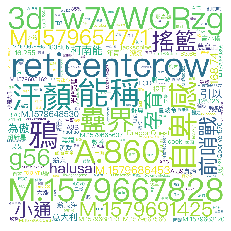

In [335]:
tfidfMerge=dict()
#for d in tfidfList:
#    tfidfMerge.update(d)

tfidfMerge=dict()
for d in tfidfList:
    for k,v in d.items():
        if k in tfidfMerge:
            if tfidfMerge[k]<v:
                tfidfMerge[k]=v
        else:
            tfidfMerge[k]=v

tfidfMerge={k: v for k, v in sorted(tfidfMerge.items(), key=lambda item: item[1],reverse=True)}

#print(type(tfidfList[0]))
font_path="/System/Library/fonts/PingFang.ttc"
wordcloud = WordCloud(background_color="white",font_path=font_path,width=1000,height=1000,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(tfidfMerge)

#wordcloud = WordCloud(background_color="white",width=1000, height=860, margin=2).generate("Ob Bc debugC")
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

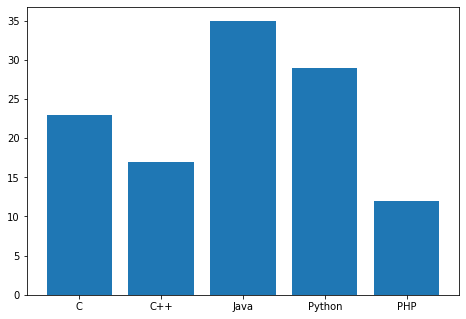

In [2]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['C', 'C++', 'Java', 'Python', 'PHP']
students = [23,17,35,29,12]
ax.bar(langs,students)
plt.show()

In [336]:
#整理政黑資料
index=0
for d in tfidfList:
    for k,v in d.items():
        if v>0 and k in political:
            temp=dict()
            authorInfo[index].update({k:v})
    index+=1

#網軍判斷

In [337]:
political_max = 1
political_info = dict(list(dict()))

#判斷政治用語詞頻分佈
for index in authorInfo:
    #print(len(authorInfo[index]),authorInfo[index]['ip'])
    if len(authorInfo[index]) > political_max:
        ip=authorInfo[index]['ip']
        author=authorInfo[index]['author']
        url=authorInfo[index]['url']
        if ip in political_info:
            if author not in political_info[ip][0].values():
                print('ponccQQ',ip,author,':',political_info[ip])
                tempList=political_info[ip];
                tempList.append({'author':author,'url':url,'count':len(authorInfo[index])})
                political_info[ip]=tempList
            else:
                tempList=political_info[ip];
                tempList.append({'author':author,'url':url,'count':len(authorInfo[index])})
                political_info[ip]=tempList
        else:    
            tempList=list()
            tempList.append({'author':author,'url':url,'count':len(authorInfo[index])})
            political_info[ip] = tempList
    #for k,v in authorInfo[index].items():
    #    if k in political:
    #        x=1
#            print(k)
for i in political_info:
    #print(len(political_info[i]))
    if len(political_info[i]) > 1:
        for l in political_info[i]:
            print('網軍:',i,'count:',len(political_info[i]),'info:',l['author'],l['url'])
political_info

ponccQQ 118.161.247.181 Tiiek (AAAAAAAAAAAAAAAAAA) : [{'author': 'ROCisChina (中華民國才是中國)', 'url': 'https://www.ptt.cc/bbs/Gossiping/M.1579690302.A.527.html', 'count': 4}]
ponccQQ  legos4710 (EG) : [{'author': 'DataMaster (0.0)', 'url': 'https://www.ptt.cc/bbs/Gossiping/M.1579689830.A.461.html', 'count': 3}]
ponccQQ 101.9.180.100 SSZZ77 (甲殼類過敏) : [{'author': 'z72117211 (高橋李依我老婆)', 'url': 'https://www.ptt.cc/bbs/Gossiping/M.1579689118.A.C70.html', 'count': 3}]
ponccQQ 39.8.126.99 math520 ( ) : [{'author': 'a6000200 (aa)', 'url': 'https://www.ptt.cc/bbs/Gossiping/M.1579687038.A.52C.html', 'count': 3}]
ponccQQ 42.76.192.175 sqin (學店企鵝橘子) : [{'author': 'sqin (學店企鵝姆咪)', 'url': 'https://www.ptt.cc/bbs/Gossiping/M.1579679166.A.C90.html', 'count': 3}]
ponccQQ 211.72.175.250 obey1110 (obey) : [{'author': 'xamous (一天死去一點)', 'url': 'https://www.ptt.cc/bbs/Gossiping/M.1579663973.A.C70.html', 'count': 5}]
ponccQQ 163.15.161.247 a89182a89182 (豬豬肉桂卷) : [{'author': 's1155697 (0.0)', 'url': 'https://www.

網軍: 49.216.24.76 count: 2 info: ss311tw (戰神東方祥) https://www.ptt.cc/bbs/Gossiping/M.1579666482.A.755.html
網軍: 49.214.141.66 count: 2 info: sss1234 (簡簡單單) https://www.ptt.cc/bbs/Gossiping/M.1579668982.A.912.html
網軍: 49.214.141.66 count: 2 info: sss1234 (簡簡單單) https://www.ptt.cc/bbs/Gossiping/M.1579648530.A.0A2.html
網軍: 106.1.81.73 count: 2 info: t00012 (第六天蛇王) https://www.ptt.cc/bbs/Gossiping/M.1579669443.A.899.html
網軍: 106.1.81.73 count: 2 info: t00012 (第六天蛇王) https://www.ptt.cc/bbs/Gossiping/M.1579659257.A.377.html
網軍: 1.168.195.51 count: 2 info: Kitakami (公主連結特約工讀生) https://www.ptt.cc/bbs/Gossiping/M.1579668352.A.F1E.html
網軍: 1.168.195.51 count: 2 info: Kitakami (公主連結特約工讀生) https://www.ptt.cc/bbs/Gossiping/M.1579657189.A.02E.html
網軍: 114.136.126.208 count: 2 info: ianlin1216 (伊恩可可) https://www.ptt.cc/bbs/Gossiping/M.1579667409.A.7B4.html
網軍: 114.136.126.208 count: 2 info: ianlin1216 (伊恩可可) https://www.ptt.cc/bbs/Gossiping/M.1579653420.A.566.html
網軍: 1.165.89.150 count: 3 info: qqq8711

{'1.165.87.196': [{'author': 'koei0001 (魯國人)',
   'url': 'https://www.ptt.cc/bbs/Gossiping/M.1579691476.A.228.html',
   'count': 6}],
 '114.46.5.62': [{'author': 'COLONELLIU (勇嵐叫共九逃)',
   'url': 'https://www.ptt.cc/bbs/Gossiping/M.1579691513.A.69B.html',
   'count': 3}],
 '101.14.131.242': [{'author': 'algebraic (algebraic)',
   'url': 'https://www.ptt.cc/bbs/Gossiping/M.1579691614.A.FD9.html',
   'count': 3}],
 '223.138.6.34': [{'author': 'Yolosnow (生活很無聊)',
   'url': 'https://www.ptt.cc/bbs/Gossiping/M.1579691656.A.8B4.html',
   'count': 4},
  {'author': 'Yolosnow (生活很無聊)',
   'url': 'https://www.ptt.cc/bbs/Gossiping/M.1579691030.A.359.html',
   'count': 3}],
 '36.228.112.170': [{'author': 'MizunaRei (みづなれい)',
   'url': 'https://www.ptt.cc/bbs/Gossiping/M.1579691680.A.2F3.html',
   'count': 3}],
 '117.56.186.115': [{'author': 'lh9059 (Phoenix)',
   'url': 'https://www.ptt.cc/bbs/Gossiping/M.1579691803.A.56B.html',
   'count': 3},
  {'author': 'lh9059 (Phoenix)',
   'url': 'https://ww

In [364]:
#wordSet=set()
#authorInfo=dict()
wordContentList=dict(list())
#response = requests.get('https://www.ptt.cc/bbs/Gossiping/M.1587746924.A.9DC.html', cookies={'over18': '1'})
#response = requests.get('https://www.ptt.cc/bbs/Gossiping/M.1587823974.A.884.html', cookies={'over18': '1'})
response = requests.get('https://www.ptt.cc/bbs/Gossiping/M.1579659530.A.2EB.html', cookies={'over18': '1'})

#response = requests.get(url, cookies={'over18': '1'})
#print(response)
# 假設網頁回應不是 200 OK 的話, 我們視為傳送請求失敗
if response.status_code != 200:
    print('Error - {} is not available to access'.format(url))
    

# 將網頁回應的 HTML 傳入 BeautifulSoup 解析器, 方便我們根據標籤 (tag) 資訊去過濾尋找
soup = BeautifulSoup(response.text)

# 取得文章內容主體
main_content = soup.find(id='main-content')

# 取得作者資訊
author = main_content.find_all('span',class_='article-meta-value')[0].text
ip=''
for contentInfo in main_content.find_all('span',class_='f2'):
    if '※ 發信站: 批踢踢實業坊(ptt.cc), 來自: ' in contentInfo.text:
        ip = filterIP(contentInfo.text)
date=''
for contentInfo in main_content.find_all('span',class_='article-meta-value'):
    try:
        date=datetime.strptime(contentInfo.text, "%a %b %d %H:%M:%S %Y")
    except:
        print("time Error:",contentInfo.text)
    #print('date::',contentInfo.text)
    
    

# 移除文章主體中 '※ 發信站:', '◆ From:', 空行及多餘空白 (※ = u'\u203b', ◆ = u'\u25c6')
# 保留英數字, 中文及中文標點, 網址, 部分特殊符號
#
# 透過 .stripped_strings 的方式可以快速移除多餘空白並取出文字, 可參考官方文件 
#  - https://www.crummy.com/software/BeautifulSoup/bs4/doc/#strings-and-stripped-strings
filtered = []
for v in main_content.stripped_strings:
    # 假如字串開頭不是特殊符號或是以 '--' 開頭的, 我們都保留其文字
    if v[0] not in [u'※', u'◆'] and v[:2] not in [u'--']:
        filtered.append(v)

# 定義一些特殊符號與全形符號的過濾器
expr = re.compile(u'[^一-龥。；，：“”（）、？《》\s\w:/-_.?~%()]')
for i in range(len(filtered)):
    filtered[i] = re.sub(expr, '', filtered[i])

# 移除空白字串, 組合過濾後的文字即為文章本文 (content)
filtered = [i for i in filtered if i]
content = ' '.join(filtered)
#print(content)

wordSet,wordContentList=jiebaContent(stopwords,wordSet,content)

#authorInfo[count]={ip:author}
tmp=dict()
tmp={'ip':ip,'author':author,'date:':date,'url':url}
print(date)
authorInfo[count]=tmp

Building prefix dict from /Users/poncc/Documents/GitHub/2nd-PyCrawlerMarathon/homework/day038/dict.user.big.txt ...
Loading model from cache /var/folders/68/t9g86v0d0ys2rpbv_g1xxrph0000gn/T/jieba.u25b0b9ddcb92304ec71499048447de52.cache


time Error: askingts (地獄山貓)
time Error: Gossiping
time Error: Re: [新聞] 再選宜蘭縣長？ 陳歐珀︰沒承諾不選


Loading model cost 1.069 seconds.
Prefix dict has been built successfully.


2020-01-22 10:18:48


In [ ]:
x=[{'author': 'askingts (地獄山貓)', 'url': 'https://www.ptt.cc/bbs/Gossiping/M.1579659530.A.2EB.html', 'count': 4}]
if 'askingts (獄山貓)' in x[0].values():
    print('aaaaa')
print(x[0])

In [360]:

#datetime.strptime("Wed Jan 22 10:18:48 2020", "%a %b %d %H:%m:%S %d")
s=datetime.strptime("Wed Jan 22 10:18:48 2020", "%a %b %d %H:%M:%S %Y")
#s = datetime.strptime("2018-01-31", "%Y-%m-%d")
print(s)

2020-01-22 10:18:48


In [ ]:

#tempList=list();
#tempList=[1:2]